In [1]:
!pip install varname

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, cv2, shutil, random
import json
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage import io
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from requests.compat import urlparse, urlunparse, urljoin
from bs4 import BeautifulSoup
import re
import requests
from requests import Session, request, get
import urllib.request
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
from varname import nameof
from functools import reduce 
import sqlite3
import random

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import resnet, resnet_v2, ResNet50, ResNet50V2, EfficientNetB3, InceptionV3, InceptionResNetV2
from tensorboard.plugins import projector

In [5]:
def myPreprocess_image_fin(fname):
  try:
    image_string = tf.io.read_file(fname)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224,224,3)[:2]) # TARGET_SHAPE
    return image
  except:
    print(fname)

In [6]:
def visualize(anchor, positive, negative, n=3):
    """Visualize triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(3*n, 9))

    axs = fig.subplots(n, 3)
    for i in range(n):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [ ]:
def substitute(url):
    base_dir = r"/content/drive/Othercomputers/내 노트북 (2)/test_002013"
    for i in os.listdir(base_dir):
        if i == (url.split('/')[-2] + '_' + url.split('/')[-1][:-4] + '.' + url[-3:]):
            try:
                if tf.io.read_file(os.path.join(base_dir ,i)):
                    return os.path.join(base_dir ,i)
            except:
                return "0"
    return "0"

In [7]:
def create_negative(dataframe, idx): 

    rand_int = random.randint(0, len(dataframe)-1)
    if dataframe.loc[idx, "goods_id"] != dataframe.loc[rand_int, "goods_id"]:
        dataframe.loc[idx, "negative"] = dataframe.loc[rand_int, "positive"]
        
    else:
        create_negative(dataframe, idx)

Load Data

In [8]:
df_styleReview_merge = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_pure.csv", dtype=object)

In [9]:
sample_path_drive = []
sample_path_local = df_styleReview_merge.sample_path_local.to_list()
for i in sample_path_local:
  sample_path_drive_elm = "/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/sampleImg/" + i.split('\\')[-1]
  sample_path_drive.append(sample_path_drive_elm)

review_path_drive = []
for i, row in df_styleReview_merge.iterrows():
    base_dir = "/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train"
    review_path_drive_elm = os.path.join(base_dir, row["filename"])
    review_path_drive.append(review_path_drive_elm)

df_styleReview_merge["sample_path_drive"] = sample_path_drive
df_styleReview_merge["review_path_drive"] = review_path_drive

In [10]:
df_styleReview_merge

,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,goods_id,mid_category,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive
0,25868,2776,25868_0_gallery_5bc7100bc4ff6_jpg.rf.6447220e7...,298,717,0,0,298,717,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
1,25868,1168,25868_0_gallery_5bcc87a2b5ce9_jpg.rf.b6559a493...,368,809,0,0,368,809,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
2,25868,1281,25868_0_gallery_5e57d8c343ff9_jpg.rf.bc6e3cebc...,133,373,0,0,133,373,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
3,25868,3062,25868_0_gallery_5bff80bbdad6a_jpg.rf.7201fb298...,370,583,0,0,370,583,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
4,25868,1149,25868_0_gallery_5f51a6f94de0f_jpg.rf.b63152a86...,68,166,0,0,68,166,25868,003002,https://image.msscdn.net/images/goods_img/2012...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5084,2930893,563,2930893_0_gallery_6390a095e1d56_jpg.rf.1a1691c...,181,158,0,0,181,158,2930893,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
5085,2946308,984,2946308_0_gallery_63870cdf9a6ca_jpg.rf.aed7fd1...,1252,1543,0,0,1252,1543,2946308,002021,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
5086,2946977,2536,2946977_0_gallery_638c3022598b8_jpg.rf.9983a27...,68,63,0,0,68,63,2946977,005011,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
5087,2946977,629,2946977_0_gallery_638f4eaec5812_jpg.rf.1da588c...,131,87,0,0,131,87,2946977,005011,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...


In [11]:
df_styleReview_merge.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_drive.csv", index=False)

018002

In [12]:
df_styleReview_merge_drive = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_drive.csv", dtype=object)

In [13]:
df_styleReview_018002 = df_styleReview_merge_drive.groupby("mid_category").get_group("018002") # <-- 코드 수정
df_styleReview_018002["anchor"] = df_styleReview_018002["sample_path_drive"]
df_styleReview_018002["positive"] = df_styleReview_018002["review_path_drive"]

In [14]:
df_styleReview_018002.reset_index(inplace=True)

In [15]:
sub_anchor = df_styleReview_018002["anchor"].to_list()
sub_positive = df_styleReview_018002["positive"].to_list()

In [16]:
print(df_styleReview_018002.loc[0,:]["sample_path_drive"])
print(df_styleReview_018002.loc[0,:]["sample_path_local"])
print(df_styleReview_018002.loc[0,:]["review_path_drive"])
print(df_styleReview_018002.loc[0,:]["review_path_local"])

/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/sampleImg/20140620_102618_102618_7_500.jpg
C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\12sw_project.v4i.tensorflow\sampleImg\20140620_102618_102618_7_500.jpg
/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/102618_0_gallery_60896db6ce29e_jpg.rf.fb8614434f3183587e02e2560cb4d6e8.jpg
C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\12sw_project.v4i.tensorflow\train\102618_0_gallery_60896db6ce29e_jpg.rf.fb8614434f3183587e02e2560cb4d6e8.jpg


In [17]:
anchor_tensor = list()
for i in sub_anchor:
    k = myPreprocess_image_fin(i)
    anchor_tensor.append(k)

positive_tensor = list()
for i in sub_positive:
    k = myPreprocess_image_fin(i)
    positive_tensor.append(k)
    

image_count = len(anchor_tensor)

In [18]:
for i in range(0, len(df_styleReview_018002)):
      
  create_negative(df_styleReview_018002, i)

In [19]:
sub_negative = df_styleReview_018002["negative"].to_list()
negative_tensor = list()
for i in sub_negative:
    k = myPreprocess_image_fin(i)
    negative_tensor.append(k)
    

In [20]:
df_styleReview_018002.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_018002.csv", index=False)
df_styleReview_018002 = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_018002.csv", dtype=object)

In [21]:
df_styleReview_018002

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,goods_id,mid_category,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor,positive,negative
0,14,102618,1920,102618_0_gallery_60896db6ce29e_jpg.rf.fb861443...,101,101,0,0,101,101,102618,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
1,15,102619,5082,102619_0_gallery_5f7c01c2cecdd_jpg.rf.5326f00c...,195,150,0,0,195,150,102619,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
2,16,102620,1653,102620_0_gallery_5f3fea76af653_jpg.rf.ee307bdd...,150,113,0,0,150,113,102620,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
3,17,102621,3493,102621_0_gallery_60d6e86b4795b_jpg.rf.c54e98f0...,147,52,0,0,147,52,102621,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
4,18,102621,2601,102621_0_gallery_5ed610de37ef4_jpg.rf.9b9478c3...,128,53,0,0,128,53,102621,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,4912,2821740,5304,2821740_0_gallery_635e3367e4671_jpg.rf.5d148f4...,198,143,0,0,198,143,2821740,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
462,4918,2825931,615,2825931_0_gallery_638241bb8e636_jpg.rf.1daad92...,177,169,0,0,177,169,2825931,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
463,4967,2839680,3764,2839680_0_gallery_638035c54543d_jpg.rf.d20eac0...,71,67,0,0,71,67,2839680,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1.

Training

In [32]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
TARGET_SHAPE = (224, 224, 3)
EMBEDDING_DIMENSION = 256
EPOCHS = 100

In [33]:
tf.keras.backend.clear_session()

base_model = ResNet50(weights="imagenet", input_shape=TARGET_SHAPE, include_top=False)

for layer in base_model.layers:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)

output = Dense(EMBEDDING_DIMENSION, activation="linear")(x)

embedding = Model(base_model.input, output, name="Embedding")

In [34]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = Input(name="anchor", shape=TARGET_SHAPE)
positive_input = Input(name="positive", shape=TARGET_SHAPE)
negative_input = Input(name="negative", shape=TARGET_SHAPE)

distances = DistanceLayer()(embedding(resnet.preprocess_input(anchor_input)), embedding(resnet.preprocess_input(positive_input)), embedding(resnet.preprocess_input(negative_input)))

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [35]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

빼고 다시 ..

In [36]:
# df_photoReview_001_selected_apn.drop([369, 2017, 4508, 5157, 6011, 6573, 6697, 6727, 6945, 8840,3189, 3271, \
#                                       3290, 3376, 3385, 3431, 3475, 3552, 3828, 3871, 3941],axis=0, inplace=True)

In [ ]:
# df_photoReview_001_selected_apn_001001 = df_photoReview_001_selected_apn.groupby("mid_category").get_group("001001")

In [ ]:
# sub_anchor = df_photoReview_001_selected_apn_001001.image_path_sample_drive.to_list()
# sub_positive = df_photoReview_001_selected_apn_001001.image_path_review_drive.to_list()
# sub_negative = df_photoReview_001_selected_apn_001001.image_path_negative_drive.to_list()

In [ ]:
# anchor_tensor = list()
# for i in sub_anchor:
#     k = myPreprocess_image_fin(i)
#     anchor_tensor.append(k)

# positive_tensor = list()
# for i in sub_positive:
#     k = myPreprocess_image_fin(i)
#     positive_tensor.append(k)
    
# negative_tensor = list()    
# for i in sub_negative:
#     k = myPreprocess_image_fin(i)
#     negative_tensor.append(k)

# image_count = len(anchor_tensor)

In [37]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_tensor)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_tensor)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_tensor)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
# dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [38]:
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None))>

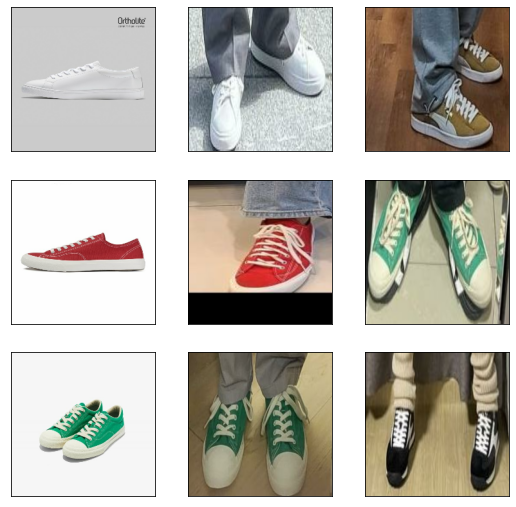

In [39]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', mode='auto', patience=10, restore_best_weights=True)]

In [41]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), metrics=['accuracy'])
history = siamese_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.6331

6/6 [==============================] - 18s 1s/step - loss: 0.6331 - val_loss: 0.4923
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.4365

6/6 [==============================] - 2s 413ms/step - loss: 0.4365 - val_loss: 0.4603
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.4224

6/6 [==============================] - 2s 415ms/step - loss: 0.4224 - val_loss: 0.3711
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.3834

6/6 [==============================] - 2s 413ms/step - loss: 0.3834 - val_loss: 0.2877
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0.3492

6/6 [==============================] - 2s 374ms/step - loss: 0.3492 - val_loss: 0.3773
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 0.3112

6/6 [==============================] - 2s 414ms/step - loss: 0.3112 - val_loss: 0.2501
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 0.2874

6/6 [==============================] - 2s 413ms/step - loss: 0.2874 - val_loss: 0.2038
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 0.2683

6/6 [==============================] - 2s 373ms/step - loss: 0.2683 - val_loss: 0.2184
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 0.2439

6/6 [==============================] - 2s 372ms/step - loss: 0.2439 - val_loss: 0.2217
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 0.2301

6/6 [==============================] - 2s 373ms/step - loss: 0.2301 - val_loss: 0.2513
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 0.2053

6/6 [==============================] - 2s 373ms/step - loss: 0.2053 - val_loss: 0.2178
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 0.1840

6/6 [==============================] - 2s 415ms/step - loss: 0.1840 - val_loss: 0.1726
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 0.1862

6/6 [==============================] - 2s 414ms/step - loss: 0.1862 - val_loss: 0.1371
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 0.1538

6/6 [==============================] - 2s 413ms/step - loss: 0.1538 - val_loss: 0.0993
Epoch 15/100
6/6 [==============================] - ETA: 0s - loss: 0.1453

6/6 [==============================] - 2s 374ms/step - loss: 0.1453 - val_loss: 0.1427
Epoch 16/100
6/6 [==============================] - ETA: 0s - loss: 0.1397

6/6 [==============================] - 2s 373ms/step - loss: 0.1397 - val_loss: 0.1068
Epoch 17/100
6/6 [==============================] - ETA: 0s - loss: 0.1345

6/6 [==============================] - 2s 373ms/step - loss: 0.1345 - val_loss: 0.1315
Epoch 18/100
6/6 [==============================] - ETA: 0s - loss: 0.1305

6/6 [==============================] - 2s 373ms/step - loss: 0.1305 - val_loss: 0.1215
Epoch 19/100
6/6 [==============================] - ETA: 0s - loss: 0.1210

6/6 [==============================] - 2s 411ms/step - loss: 0.1210 - val_loss: 0.0989
Epoch 20/100
6/6 [==============================] - ETA: 0s - loss: 0.1112

6/6 [==============================] - 2s 413ms/step - loss: 0.1112 - val_loss: 0.0879
Epoch 21/100
6/6 [==============================] - ETA: 0s - loss: 0.0995

6/6 [==============================] - 2s 373ms/step - loss: 0.0995 - val_loss: 0.1371
Epoch 22/100
6/6 [==============================] - ETA: 0s - loss: 0.1122

6/6 [==============================] - 2s 372ms/step - loss: 0.1122 - val_loss: 0.0967
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 0.0984

6/6 [==============================] - 2s 411ms/step - loss: 0.0984 - val_loss: 0.0415
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 0.0864

6/6 [==============================] - 2s 373ms/step - loss: 0.0864 - val_loss: 0.0858
Epoch 25/100
6/6 [==============================] - ETA: 0s - loss: 0.0755

6/6 [==============================] - 2s 375ms/step - loss: 0.0755 - val_loss: 0.0472
Epoch 26/100
6/6 [==============================] - ETA: 0s - loss: 0.0609

6/6 [==============================] - 2s 373ms/step - loss: 0.0609 - val_loss: 0.0471
Epoch 27/100
6/6 [==============================] - ETA: 0s - loss: 0.0696

6/6 [==============================] - 2s 373ms/step - loss: 0.0696 - val_loss: 0.0637
Epoch 28/100
6/6 [==============================] - ETA: 0s - loss: 0.0526

6/6 [==============================] - 2s 412ms/step - loss: 0.0526 - val_loss: 0.0397
Epoch 29/100
6/6 [==============================] - ETA: 0s - loss: 0.0323

6/6 [==============================] - 2s 414ms/step - loss: 0.0323 - val_loss: 0.0315
Epoch 30/100
6/6 [==============================] - ETA: 0s - loss: 0.0420

6/6 [==============================] - 2s 373ms/step - loss: 0.0420 - val_loss: 0.0391
Epoch 31/100
6/6 [==============================] - ETA: 0s - loss: 0.0252

6/6 [==============================] - 2s 372ms/step - loss: 0.0252 - val_loss: 0.0348
Epoch 32/100
6/6 [==============================] - ETA: 0s - loss: 0.0222

6/6 [==============================] - 2s 415ms/step - loss: 0.0222 - val_loss: 0.0073
Epoch 33/100
6/6 [==============================] - ETA: 0s - loss: 0.0258

6/6 [==============================] - 2s 373ms/step - loss: 0.0258 - val_loss: 0.0142
Epoch 34/100
6/6 [==============================] - ETA: 0s - loss: 0.0318

6/6 [==============================] - 2s 372ms/step - loss: 0.0318 - val_loss: 0.0391
Epoch 35/100
6/6 [==============================] - ETA: 0s - loss: 0.0188

6/6 [==============================] - 2s 372ms/step - loss: 0.0188 - val_loss: 0.0209
Epoch 36/100
6/6 [==============================] - ETA: 0s - loss: 0.0377

6/6 [==============================] - 2s 372ms/step - loss: 0.0377 - val_loss: 0.0303
Epoch 37/100
6/6 [==============================] - ETA: 0s - loss: 0.0344

6/6 [==============================] - 2s 373ms/step - loss: 0.0344 - val_loss: 0.0299
Epoch 38/100
6/6 [==============================] - ETA: 0s - loss: 0.0206

6/6 [==============================] - 2s 373ms/step - loss: 0.0206 - val_loss: 0.0207
Epoch 39/100
6/6 [==============================] - ETA: 0s - loss: 0.0202

6/6 [==============================] - 3s 437ms/step - loss: 0.0202 - val_loss: 0.0072
Epoch 40/100
6/6 [==============================] - ETA: 0s - loss: 0.0241

6/6 [==============================] - 2s 373ms/step - loss: 0.0241 - val_loss: 0.0294
Epoch 41/100
6/6 [==============================] - ETA: 0s - loss: 0.0163

6/6 [==============================] - 2s 373ms/step - loss: 0.0163 - val_loss: 0.0155
Epoch 42/100
6/6 [==============================] - ETA: 0s - loss: 0.0179

6/6 [==============================] - 2s 372ms/step - loss: 0.0179 - val_loss: 0.0204
Epoch 43/100
6/6 [==============================] - ETA: 0s - loss: 0.0192

6/6 [==============================] - 2s 373ms/step - loss: 0.0192 - val_loss: 0.0088
Epoch 44/100
6/6 [==============================] - ETA: 0s - loss: 0.0124

6/6 [==============================] - 2s 373ms/step - loss: 0.0124 - val_loss: 0.0358
Epoch 45/100
6/6 [==============================] - ETA: 0s - loss: 0.0149

6/6 [==============================] - 2s 372ms/step - loss: 0.0149 - val_loss: 0.0321
Epoch 46/100
6/6 [==============================] - ETA: 0s - loss: 0.0216

6/6 [==============================] - 2s 372ms/step - loss: 0.0216 - val_loss: 0.0245
Epoch 47/100
6/6 [==============================] - ETA: 0s - loss: 0.0196

6/6 [==============================] - 2s 373ms/step - loss: 0.0196 - val_loss: 0.0152
Epoch 48/100
6/6 [==============================] - ETA: 0s - loss: 0.0193

6/6 [==============================] - 2s 414ms/step - loss: 0.0193 - val_loss: 0.0029
Epoch 49/100
6/6 [==============================] - ETA: 0s - loss: 0.0197

6/6 [==============================] - 2s 372ms/step - loss: 0.0197 - val_loss: 0.0052
Epoch 50/100
6/6 [==============================] - ETA: 0s - loss: 0.0197

6/6 [==============================] - 2s 372ms/step - loss: 0.0197 - val_loss: 0.0314
Epoch 51/100
6/6 [==============================] - ETA: 0s - loss: 0.0269

6/6 [==============================] - 2s 372ms/step - loss: 0.0269 - val_loss: 0.0116
Epoch 52/100
6/6 [==============================] - ETA: 0s - loss: 0.0196

6/6 [==============================] - 2s 374ms/step - loss: 0.0196 - val_loss: 0.0132
Epoch 53/100
6/6 [==============================] - ETA: 0s - loss: 0.0207

6/6 [==============================] - 2s 372ms/step - loss: 0.0207 - val_loss: 0.0671
Epoch 54/100
6/6 [==============================] - ETA: 0s - loss: 0.0368

6/6 [==============================] - 2s 373ms/step - loss: 0.0368 - val_loss: 0.0567
Epoch 55/100
6/6 [==============================] - ETA: 0s - loss: 0.0632

6/6 [==============================] - 2s 372ms/step - loss: 0.0632 - val_loss: 0.0220
Epoch 56/100
6/6 [==============================] - ETA: 0s - loss: 0.0437

6/6 [==============================] - 2s 373ms/step - loss: 0.0437 - val_loss: 0.0334
Epoch 57/100
6/6 [==============================] - ETA: 0s - loss: 0.0271

6/6 [==============================] - 2s 373ms/step - loss: 0.0271 - val_loss: 0.0208
Epoch 58/100
6/6 [==============================] - ETA: 0s - loss: 0.0182

6/6 [==============================] - 2s 404ms/step - loss: 0.0182 - val_loss: 0.0404


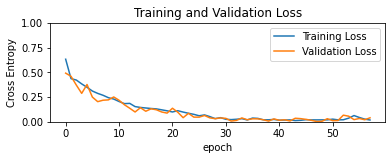

In [42]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(resnet.preprocess_input(anchor)), embedding(resnet.preprocess_input(positive)), embedding(resnet.preprocess_input(negative)),)

In [44]:
anchors, positives, negatives = sample
for i in range(len(anchor_embedding)):
    anchor, positive, negative = anchors[i], positives[i], negatives[i]
    positive_distance = np.linalg.norm(anchor_embedding[i] - positive_embedding[i], ord=2)*1e4
    negative_distance = np.linalg.norm(anchor_embedding[i] - negative_embedding[i], ord=2)*1e4
    positive_distance, negative_distance = round(positive_distance)/1e4, round(negative_distance)/1e4
    plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(anchor)
    plt.axis("off")
    plt.title("Anchor")
    plt.subplot(132)
    plt.imshow(positive)
    plt.axis("off")
    plt.title(f"Anchor to Positive Distance: {positive_distance}")
    plt.subplot(133)
    plt.imshow(negative)
    plt.axis("off")
    plt.title(f"Anchor to Negative Distance: {negative_distance}")
    plt.show()        

Output hidden; open in https://colab.research.google.com to view.

In [45]:
embedding.save("Midcateg_018002_1216.h5")

In [46]:
!cp Midcateg_018002_1216.h5 /content/drive/MyDrive/3rd_project/SiameseModels

Inference


In [47]:
TARGET_SHAPE = (224,224,3)
def preprocess_image(filename: str):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    
    Args:
        filename: Absolute / Relative file path for the image
    
    Returns:
        Preprocessed inputs of type tensorflow.Tensor for Embedding Generation 
    """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE[:2])
    image = resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0)


def generate_embedding(dataframe, embedding_generator):
    """
    Use the specified dataframe and Embeddings model to 
    calculate embeddings for all records in the dataframe
    
    Args:
        dataframe: Dataframe to get records for Embedding Generation
        embedding_genrator: Tensorflow Model to generate embeddings
    
    Returns:
        Dataframe with embeddings for each record.
    """
    embeddings_review = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["review_path_drive"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_review.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_review"] = embeddings_review
    embeddings_sample = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["sample_path_drive"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_sample.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_sample"] = embeddings_sample
    return dataframe

In [48]:
Midclass018002 = load_model("/content/drive/MyDrive/3rd_project/SiameseModels/Midcateg_018002_1216.h5", compile=False)

In [49]:
df_styleReview_018002 = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_018002.csv", dtype=object)
df_styleReview_018002

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,goods_id,mid_category,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor,positive,negative
0,14,102618,1920,102618_0_gallery_60896db6ce29e_jpg.rf.fb861443...,101,101,0,0,101,101,102618,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
1,15,102619,5082,102619_0_gallery_5f7c01c2cecdd_jpg.rf.5326f00c...,195,150,0,0,195,150,102619,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
2,16,102620,1653,102620_0_gallery_5f3fea76af653_jpg.rf.ee307bdd...,150,113,0,0,150,113,102620,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
3,17,102621,3493,102621_0_gallery_60d6e86b4795b_jpg.rf.c54e98f0...,147,52,0,0,147,52,102621,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
4,18,102621,2601,102621_0_gallery_5ed610de37ef4_jpg.rf.9b9478c3...,128,53,0,0,128,53,102621,018002,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,4912,2821740,5304,2821740_0_gallery_635e3367e4671_jpg.rf.5d148f4...,198,143,0,0,198,143,2821740,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
462,4918,2825931,615,2825931_0_gallery_638241bb8e636_jpg.rf.1daad92...,177,169,0,0,177,169,2825931,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...
463,4967,2839680,3764,2839680_0_gallery_638035c54543d_jpg.rf.d20eac0...,71,67,0,0,71,67,2839680,018002,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1.

In [50]:
df_styleReview_018002_sim = generate_embedding(df_styleReview_018002, Midclass018002)
df_styleReview_018002_sim.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_018002_sim.csv", index=False)
df_styleReview_018002_sim = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_018002_sim.csv", dtype=object)

100%|██████████| 466/466 [00:34<00:00, 13.54it/s]


In [51]:
df_styleReview_018002_sim

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor,positive,negative,embedding_review,embedding_sample
0,14,102618,1920,102618_0_gallery_60896db6ce29e_jpg.rf.fb861443...,101,101,0,0,101,101,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.6391469836235046, -3.0516769886016846, -0.8...","[0.837113618850708, -2.9201419353485107, -0.94..."
1,15,102619,5082,102619_0_gallery_5f7c01c2cecdd_jpg.rf.5326f00c...,195,150,0,0,195,150,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7569023966789246, -2.6836259365081787, -0.8...","[0.7967178225517273, -2.777855396270752, -0.97..."
2,16,102620,1653,102620_0_gallery_5f3fea76af653_jpg.rf.ee307bdd...,150,113,0,0,150,113,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7257656455039978, -2.764057159423828, -0.98...","[0.9360645413398743, -3.013759136199951, -0.87..."
3,17,102621,3493,102621_0_gallery_60d6e86b4795b_jpg.rf.c54e98f0...,147,52,0,0,147,52,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7693579196929932, -2.720442056655884, -0.91...","[0.8840537667274475, -3.0033762454986572, -0.9..."
4,18,102621,2601,102621_0_gallery_5ed610de37ef4_jpg.rf.9b9478c3...,128,53,0,0,128,53,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7515172958374023, -2.9423694610595703, -0.7...","[0.8840537667274475, -3.0033762454986572, -0.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,4912,2821740,5304,2821740_0_gallery_635e3367e4671_jpg.rf.5d148f4...,198,143,0,0,198,143,...,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7651652097702026, -2.7144157886505127, -0.8...","[0.6760578155517578, -2.8619422912597656, -0.9..."
462,4918,2825931,615,2825931_0_gallery_638241bb8e636_jpg.rf.1daad92...,177,169,0,0,177,169,...,https://image.msscdn.net/ima

임의의 행의 리리

100%|██████████| 466/466 [00:00<00:00, 895.86it/s]


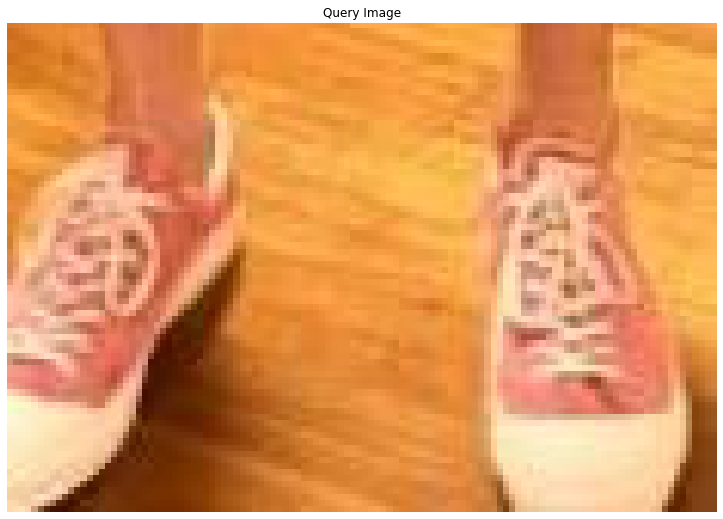

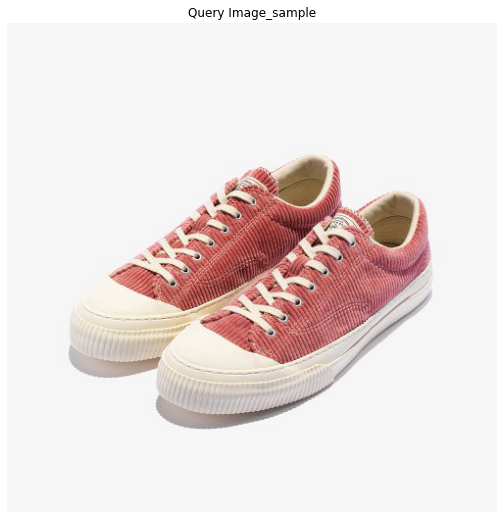

2163923


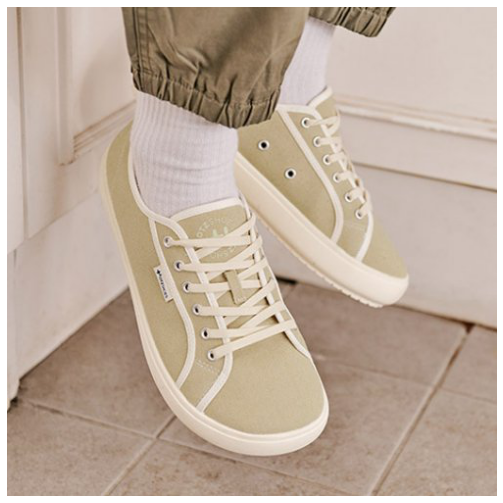

유사도 :  0.6754807829856873
1794627
Shop Now @  https://musinsa.com/app/goods/1794627


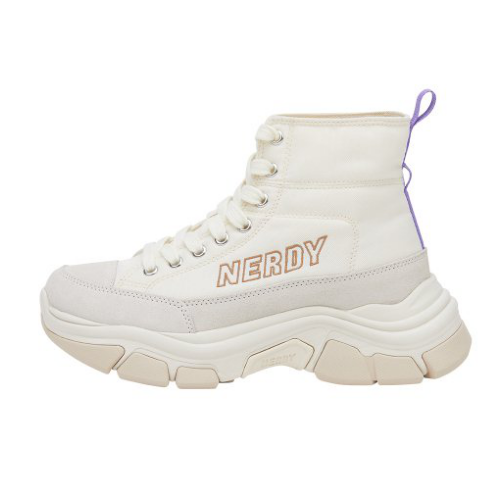

유사도 :  0.8049631118774414
1888364
Shop Now @  https://musinsa.com/app/goods/1888364


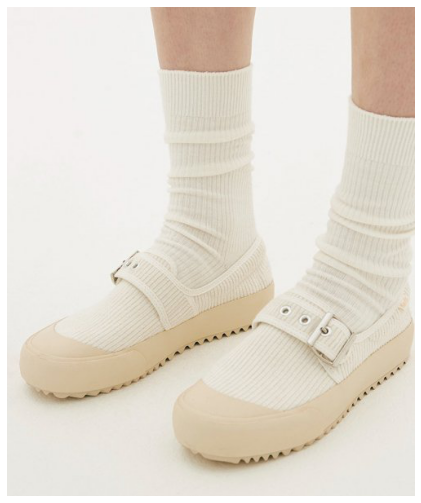

유사도 :  0.8460463285446167
2794903
Shop Now @  https://musinsa.com/app/goods/2794903


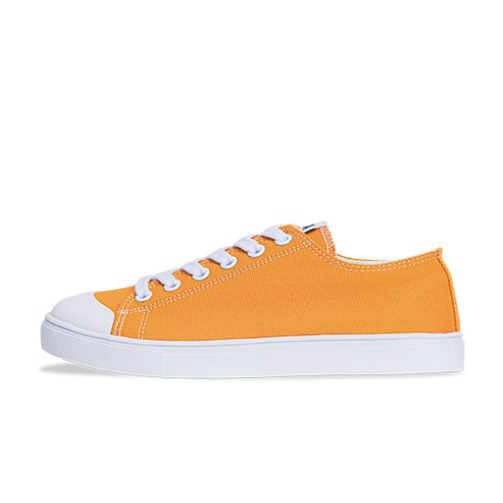

유사도 :  0.8697564601898193
1007720
Shop Now @  https://musinsa.com/app/goods/1007720


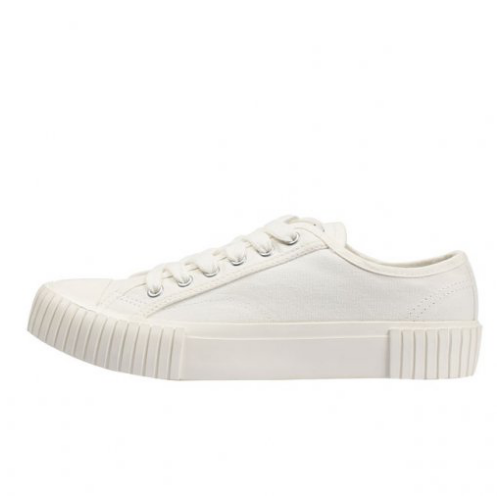

유사도 :  0.9022881388664246
807535
Shop Now @  https://musinsa.com/app/goods/807535


In [52]:
 tqdm.pandas()
query_row = df_styleReview_018002_sim.iloc[random.randint(0,df_styleReview_018002_sim.shape[0])] 
query_embedding = query_row.embedding_review
a = query_row["goods_id_pure"] 
b = query_row.review_path_drive
c = query_row.sample_path_drive
df_styleReview_018002_sim['distance_samImg_queryRev'] = df_styleReview_018002_sim['embedding_sample'].progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(query_embedding), dtype=np.float32)))
df_styleReview_018002_sim = df_styleReview_018002_sim.sort_values(by='distance_samImg_queryRev').reset_index(drop=True)
plt.figure(figsize=(16,9))
plt.imshow(io.imread(b))
plt.title("Query Image")
plt.axis("off");plt.show()
plt.figure(figsize=(16,9))
plt.imshow(io.imread(c))
plt.title("Query Image_sample")
plt.axis("off");plt.show()
print(a)
print(254*"=")
print(254*"=")
j = 0
for i, row in df_styleReview_018002_sim.drop_duplicates("goods_id_pure",inplace=False).iloc[:5, :].iterrows():
    j += 1
    plt.figure(figsize=(16,9))
    image = io.imread(row["sample_path_drive"])
    plt.imshow(image);plt.axis("off")
    plt.show()
    print("유사도 : ", row["distance_samImg_queryRev"])
    print(row["goods_id_pure"])
    if a == row["goods_id_pure"] :
      print(j, "번 째 일치")
    print("Shop Now @ ", ("https://musinsa.com/app/goods/" + row["goods_id_pure"]))


In [54]:
df_styleReview_018002_sim = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_018002_sim.csv", dtype=object)
df_styleReview_018002_sim 

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,goods_image,sample_path_local,review_path_local,sample_path_drive,review_path_drive,anchor,positive,negative,embedding_review,embedding_sample
0,14,102618,1920,102618_0_gallery_60896db6ce29e_jpg.rf.fb861443...,101,101,0,0,101,101,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.6391469836235046, -3.0516769886016846, -0.8...","[0.837113618850708, -2.9201419353485107, -0.94..."
1,15,102619,5082,102619_0_gallery_5f7c01c2cecdd_jpg.rf.5326f00c...,195,150,0,0,195,150,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7569023966789246, -2.6836259365081787, -0.8...","[0.7967178225517273, -2.777855396270752, -0.97..."
2,16,102620,1653,102620_0_gallery_5f3fea76af653_jpg.rf.ee307bdd...,150,113,0,0,150,113,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7257656455039978, -2.764057159423828, -0.98...","[0.9360645413398743, -3.013759136199951, -0.87..."
3,17,102621,3493,102621_0_gallery_60d6e86b4795b_jpg.rf.c54e98f0...,147,52,0,0,147,52,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7693579196929932, -2.720442056655884, -0.91...","[0.8840537667274475, -3.0033762454986572, -0.9..."
4,18,102621,2601,102621_0_gallery_5ed610de37ef4_jpg.rf.9b9478c3...,128,53,0,0,128,53,...,https://image.msscdn.net/images/goods_img/2014...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7515172958374023, -2.9423694610595703, -0.7...","[0.8840537667274475, -3.0033762454986572, -0.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,4912,2821740,5304,2821740_0_gallery_635e3367e4671_jpg.rf.5d148f4...,198,143,0,0,198,143,...,https://image.msscdn.net/images/goods_img/2022...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,/content/drive/Othercomputers/내 노트북/12sw_proje...,"[0.7651652097702026, -2.7144157886505127, -0.8...","[0.6760578155517578, -2.8619422912597656, -0.9..."
462,4918,2825931,615,2825931_0_gallery_638241bb8e636_jpg.rf.1daad92...,177,169,0,0,177,169,...,https://image.msscdn.net/ima

In [55]:
for i, row in df_styleReview_018002_sim.iterrows(): # 리뷰 사진 임베딩 기준 
    row_embedding = row.embedding_review
    df_styleReview_018002_sim['distance_{}'.format(row.positive)] = df_styleReview_018002_sim['embedding_review']\
    .progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(row_embedding), dtype=np.float32)))
    # row * row
    print(i, "완료")
df_styleReview_018002_sim

100%|██████████| 466/466 [00:00<00:00, 913.96it/s]


0 완료


100%|██████████| 466/466 [00:00<00:00, 901.11it/s]


1 완료


100%|██████████| 466/466 [00:00<00:00, 915.80it/s]


2 완료


100%|██████████| 466/466 [00:00<00:00, 892.54it/s]


3 완료


100%|██████████| 466/466 [00:00<00:00, 896.71it/s]


4 완료


100%|██████████| 466/466 [00:00<00:00, 906.22it/s]


5 완료


100%|██████████| 466/466 [00:00<00:00, 919.03it/s]


6 완료


100%|██████████| 466/466 [00:00<00:00, 899.18it/s]


7 완료


100%|██████████| 466/466 [00:00<00:00, 910.05it/s]


8 완료


100%|██████████| 466/466 [00:00<00:00, 920.73it/s]


9 완료


100%|██████████| 466/466 [00:00<00:00, 908.99it/s]


10 완료


100%|██████████| 466/466 [00:00<00:00, 917.81it/s]


11 완료


100%|██████████| 466/466 [00:00<00:00, 899.25it/s]


12 완료


100%|██████████| 466/466 [00:00<00:00, 908.52it/s]


13 완료


100%|██████████| 466/466 [00:00<00:00, 918.29it/s]


14 완료


100%|██████████| 466/466 [00:00<00:00, 917.42it/s]


15 완료


100%|██████████| 466/466 [00:00<00:00, 913.21it/s]


16 완료


100%|██████████| 466/466 [00:00<00:00, 912.40it/s]


17 완료


100%|██████████| 466/466 [00:00<00:00, 909.66it/s]


18 완료


100%|██████████| 466/466 [00:00<00:00, 885.32it/s]


19 완료


100%|██████████| 466/466 [00:00<00:00, 904.00it/s]


20 완료


100%|██████████| 466/466 [00:00<00:00, 918.97it/s]


21 완료


100%|██████████| 466/466 [00:00<00:00, 904.75it/s]


22 완료


100%|██████████| 466/466 [00:00<00:00, 905.90it/s]


23 완료


100%|██████████| 466/466 [00:00<00:00, 911.35it/s]


24 완료


100%|██████████| 466/466 [00:00<00:00, 907.38it/s]


25 완료


100%|██████████| 466/466 [00:00<00:00, 920.64it/s]


26 완료


100%|██████████| 466/466 [00:00<00:00, 909.29it/s]


27 완료


100%|██████████| 466/466 [00:00<00:00, 893.77it/s]


28 완료


100%|██████████| 466/466 [00:00<00:00, 919.45it/s]


29 완료


100%|██████████| 466/466 [00:00<00:00, 919.15it/s]


30 완료


100%|██████████| 466/466 [00:00<00:00, 912.76it/s]


31 완료


100%|██████████| 466/466 [00:00<00:00, 905.76it/s]


32 완료


100%|██████████| 466/466 [00:00<00:00, 914.59it/s]


33 완료


100%|██████████| 466/466 [00:00<00:00, 922.79it/s]


34 완료


100%|██████████| 466/466 [00:00<00:00, 913.42it/s]


35 완료


100%|██████████| 466/466 [00:00<00:00, 904.80it/s]


36 완료


100%|██████████| 466/466 [00:00<00:00, 925.35it/s]


37 완료


100%|██████████| 466/466 [00:00<00:00, 906.89it/s]


38 완료


100%|██████████| 466/466 [00:00<00:00, 905.69it/s]


39 완료


100%|██████████| 466/466 [00:00<00:00, 916.30it/s]


40 완료


100%|██████████| 466/466 [00:00<00:00, 910.45it/s]


41 완료


100%|██████████| 466/466 [00:00<00:00, 893.79it/s]


42 완료


100%|██████████| 466/466 [00:00<00:00, 909.23it/s]


43 완료


100%|██████████| 466/466 [00:00<00:00, 921.04it/s]


44 완료


100%|██████████| 466/466 [00:00<00:00, 903.70it/s]


45 완료


100%|██████████| 466/466 [00:00<00:00, 905.90it/s]


46 완료


100%|██████████| 466/466 [00:00<00:00, 889.06it/s]


47 완료


100%|██████████| 466/466 [00:00<00:00, 911.87it/s]


48 완료


100%|██████████| 466/466 [00:00<00:00, 891.86it/s]


49 완료


100%|██████████| 466/466 [00:00<00:00, 900.52it/s]


50 완료


100%|██████████| 466/466 [00:00<00:00, 906.96it/s]


51 완료


100%|██████████| 466/466 [00:00<00:00, 908.59it/s]


52 완료


100%|██████████| 466/466 [00:00<00:00, 918.54it/s]


53 완료


100%|██████████| 466/466 [00:00<00:00, 895.95it/s]


54 완료


100%|██████████| 466/466 [00:00<00:00, 920.78it/s]


55 완료


100%|██████████| 466/466 [00:00<00:00, 917.75it/s]


56 완료


100%|██████████| 466/466 [00:00<00:00, 912.85it/s]


57 완료


100%|██████████| 466/466 [00:00<00:00, 906.44it/s]


58 완료


100%|██████████| 466/466 [00:00<00:00, 907.14it/s]


59 완료


100%|██████████| 466/466 [00:00<00:00, 919.97it/s]


60 완료


100%|██████████| 466/466 [00:00<00:00, 911.13it/s]


61 완료


100%|██████████| 466/466 [00:00<00:00, 892.27it/s]


62 완료


100%|██████████| 466/466 [00:00<00:00, 900.74it/s]


63 완료


100%|██████████| 466/466 [00:00<00:00, 914.23it/s]


64 완료


100%|██████████| 466/466 [00:00<00:00, 912.94it/s]


65 완료


100%|██████████| 466/466 [00:00<00:00, 921.28it/s]


66 완료


100%|██████████| 466/466 [00:00<00:00, 915.41it/s]


67 완료


100%|██████████| 466/466 [00:00<00:00, 905.08it/s]


68 완료


100%|██████████| 466/466 [00:00<00:00, 906.29it/s]


69 완료


100%|██████████| 466/466 [00:00<00:00, 907.95it/s]


70 완료


100%|██████████| 466/466 [00:00<00:00, 904.78it/s]


71 완료


100%|██████████| 466/466 [00:00<00:00, 919.13it/s]


72 완료


100%|██████████| 466/466 [00:00<00:00, 905.80it/s]


73 완료


100%|██████████| 466/466 [00:00<00:00, 905.76it/s]


74 완료


100%|██████████| 466/466 [00:00<00:00, 914.99it/s]


75 완료


100%|██████████| 466/466 [00:00<00:00, 925.99it/s]


76 완료


100%|██████████| 466/466 [00:00<00:00, 915.69it/s]


77 완료


100%|██████████| 466/466 [00:00<00:00, 908.11it/s]


78 완료


100%|██████████| 466/466 [00:00<00:00, 910.01it/s]


79 완료


100%|██████████| 466/466 [00:00<00:00, 911.76it/s]


80 완료


100%|██████████| 466/466 [00:00<00:00, 910.55it/s]


81 완료


100%|██████████| 466/466 [00:00<00:00, 911.85it/s]


82 완료


100%|██████████| 466/466 [00:00<00:00, 881.74it/s]


83 완료


100%|██████████| 466/466 [00:00<00:00, 903.82it/s]


84 완료


100%|██████████| 466/466 [00:00<00:00, 903.66it/s]


85 완료


100%|██████████| 466/466 [00:00<00:00, 909.96it/s]


86 완료


100%|██████████| 466/466 [00:00<00:00, 907.52it/s]


87 완료


100%|██████████| 466/466 [00:00<00:00, 925.86it/s]


88 완료


100%|██████████| 466/466 [00:00<00:00, 911.17it/s]


89 완료


100%|██████████| 466/466 [00:00<00:00, 913.71it/s]


90 완료


100%|██████████| 466/466 [00:00<00:00, 918.67it/s]


91 완료


100%|██████████| 466/466 [00:00<00:00, 923.41it/s]


92 완료


100%|██████████| 466/466 [00:00<00:00, 929.26it/s]


93 완료


100%|██████████| 466/466 [00:00<00:00, 905.07it/s]


94 완료


100%|██████████| 466/466 [00:00<00:00, 914.37it/s]


95 완료


100%|██████████| 466/466 [00:00<00:00, 917.37it/s]


96 완료


100%|██████████| 466/466 [00:00<00:00, 911.75it/s]


97 완료


100%|██████████| 466/466 [00:00<00:00, 918.95it/s]


98 완료


100%|██████████| 466/466 [00:00<00:00, 880.20it/s]


99 완료


100%|██████████| 466/466 [00:00<00:00, 913.17it/s]


100 완료


100%|██████████| 466/466 [00:00<00:00, 901.41it/s]


101 완료


100%|██████████| 466/466 [00:00<00:00, 907.97it/s]


102 완료


100%|██████████| 466/466 [00:00<00:00, 911.26it/s]


103 완료


100%|██████████| 466/466 [00:00<00:00, 906.83it/s]


104 완료


100%|██████████| 466/466 [00:00<00:00, 911.60it/s]


105 완료


100%|██████████| 466/466 [00:00<00:00, 929.71it/s]


106 완료


100%|██████████| 466/466 [00:00<00:00, 911.34it/s]


107 완료


100%|██████████| 466/466 [00:00<00:00, 915.77it/s]


108 완료


100%|██████████| 466/466 [00:00<00:00, 907.19it/s]


109 완료


100%|██████████| 466/466 [00:00<00:00, 911.96it/s]


110 완료


100%|██████████| 466/466 [00:00<00:00, 906.59it/s]


111 완료


100%|██████████| 466/466 [00:00<00:00, 909.95it/s]


112 완료


100%|██████████| 466/466 [00:00<00:00, 913.87it/s]


113 완료


100%|██████████| 466/466 [00:00<00:00, 909.60it/s]


114 완료


100%|██████████| 466/466 [00:00<00:00, 920.60it/s]


115 완료


100%|██████████| 466/466 [00:00<00:00, 901.02it/s]


116 완료


100%|██████████| 466/466 [00:00<00:00, 906.98it/s]


117 완료


100%|██████████| 466/466 [00:00<00:00, 881.97it/s]


118 완료


100%|██████████| 466/466 [00:00<00:00, 909.25it/s]


119 완료


100%|██████████| 466/466 [00:00<00:00, 898.59it/s]


120 완료


100%|██████████| 466/466 [00:00<00:00, 902.83it/s]


121 완료


100%|██████████| 466/466 [00:00<00:00, 897.15it/s]


122 완료


100%|██████████| 466/466 [00:00<00:00, 921.62it/s]


123 완료


100%|██████████| 466/466 [00:00<00:00, 918.30it/s]


124 완료


100%|██████████| 466/466 [00:00<00:00, 908.42it/s]


125 완료


100%|██████████| 466/466 [00:00<00:00, 919.74it/s]


126 완료


100%|██████████| 466/466 [00:00<00:00, 905.69it/s]


127 완료


100%|██████████| 466/466 [00:00<00:00, 915.02it/s]


128 완료


100%|██████████| 466/466 [00:00<00:00, 906.65it/s]


129 완료


100%|██████████| 466/466 [00:00<00:00, 908.15it/s]


130 완료


100%|██████████| 466/466 [00:00<00:00, 911.32it/s]


131 완료


100%|██████████| 466/466 [00:00<00:00, 911.42it/s]


132 완료


100%|██████████| 466/466 [00:00<00:00, 902.98it/s]


133 완료


100%|██████████| 466/466 [00:00<00:00, 902.54it/s]


134 완료


100%|██████████| 466/466 [00:00<00:00, 900.52it/s]


135 완료


100%|██████████| 466/466 [00:00<00:00, 908.34it/s]


136 완료


100%|██████████| 466/466 [00:00<00:00, 922.17it/s]


137 완료


100%|██████████| 466/466 [00:00<00:00, 921.83it/s]


138 완료


100%|██████████| 466/466 [00:00<00:00, 915.73it/s]


139 완료


100%|██████████| 466/466 [00:00<00:00, 917.27it/s]


140 완료


100%|██████████| 466/466 [00:00<00:00, 916.30it/s]


141 완료


100%|██████████| 466/466 [00:00<00:00, 912.95it/s]


142 완료


100%|██████████| 466/466 [00:00<00:00, 915.93it/s]


143 완료


100%|██████████| 466/466 [00:00<00:00, 901.92it/s]


144 완료


100%|██████████| 466/466 [00:00<00:00, 905.09it/s]


145 완료


100%|██████████| 466/466 [00:00<00:00, 898.68it/s]


146 완료


100%|██████████| 466/466 [00:00<00:00, 900.09it/s]


147 완료


100%|██████████| 466/466 [00:00<00:00, 919.89it/s]


148 완료


100%|██████████| 466/466 [00:00<00:00, 914.18it/s]


149 완료


100%|██████████| 466/466 [00:00<00:00, 906.77it/s]


150 완료


100%|██████████| 466/466 [00:00<00:00, 914.40it/s]


151 완료


100%|██████████| 466/466 [00:00<00:00, 911.51it/s]


152 완료


100%|██████████| 466/466 [00:00<00:00, 909.30it/s]


153 완료


100%|██████████| 466/466 [00:00<00:00, 891.02it/s]


154 완료


100%|██████████| 466/466 [00:00<00:00, 901.78it/s]


155 완료


100%|██████████| 466/466 [00:00<00:00, 913.76it/s]


156 완료


100%|██████████| 466/466 [00:00<00:00, 920.15it/s]


157 완료


100%|██████████| 466/466 [00:00<00:00, 904.26it/s]


158 완료


100%|██████████| 466/466 [00:00<00:00, 918.78it/s]


159 완료


100%|██████████| 466/466 [00:00<00:00, 913.63it/s]


160 완료


100%|██████████| 466/466 [00:00<00:00, 925.12it/s]


161 완료


100%|██████████| 466/466 [00:00<00:00, 926.24it/s]


162 완료


100%|██████████| 466/466 [00:00<00:00, 891.05it/s]


163 완료


100%|██████████| 466/466 [00:00<00:00, 894.89it/s]


164 완료


100%|██████████| 466/466 [00:00<00:00, 900.26it/s]


165 완료


100%|██████████| 466/466 [00:00<00:00, 910.74it/s]


166 완료


100%|██████████| 466/466 [00:00<00:00, 914.41it/s]


167 완료


100%|██████████| 466/466 [00:00<00:00, 915.76it/s]


168 완료


100%|██████████| 466/466 [00:00<00:00, 891.15it/s]


169 완료


100%|██████████| 466/466 [00:00<00:00, 913.97it/s]


170 완료


100%|██████████| 466/466 [00:00<00:00, 906.31it/s]


171 완료


100%|██████████| 466/466 [00:00<00:00, 896.74it/s]


172 완료


100%|██████████| 466/466 [00:00<00:00, 896.59it/s]


173 완료


100%|██████████| 466/466 [00:00<00:00, 861.11it/s]


174 완료


100%|██████████| 466/466 [00:00<00:00, 862.57it/s]


175 완료


100%|██████████| 466/466 [00:00<00:00, 909.74it/s]


176 완료


100%|██████████| 466/466 [00:00<00:00, 897.58it/s]


177 완료


100%|██████████| 466/466 [00:00<00:00, 921.89it/s]


178 완료


100%|██████████| 466/466 [00:00<00:00, 905.92it/s]


179 완료


100%|██████████| 466/466 [00:00<00:00, 905.27it/s]


180 완료


100%|██████████| 466/466 [00:00<00:00, 913.86it/s]


181 완료


100%|██████████| 466/466 [00:00<00:00, 908.81it/s]


182 완료


100%|██████████| 466/466 [00:00<00:00, 901.70it/s]


183 완료


100%|██████████| 466/466 [00:00<00:00, 907.53it/s]


184 완료


100%|██████████| 466/466 [00:00<00:00, 898.80it/s]


185 완료


100%|██████████| 466/466 [00:00<00:00, 921.70it/s]


186 완료


100%|██████████| 466/466 [00:00<00:00, 900.00it/s]


187 완료


100%|██████████| 466/466 [00:00<00:00, 902.66it/s]


188 완료


100%|██████████| 466/466 [00:00<00:00, 888.99it/s]


189 완료


100%|██████████| 466/466 [00:00<00:00, 916.50it/s]


190 완료


100%|██████████| 466/466 [00:00<00:00, 918.45it/s]


191 완료


100%|██████████| 466/466 [00:00<00:00, 910.10it/s]


192 완료


100%|██████████| 466/466 [00:00<00:00, 905.88it/s]


193 완료


100%|██████████| 466/466 [00:00<00:00, 894.00it/s]


194 완료


100%|██████████| 466/466 [00:00<00:00, 902.58it/s]


195 완료


100%|██████████| 466/466 [00:00<00:00, 917.20it/s]


196 완료


100%|██████████| 466/466 [00:00<00:00, 903.23it/s]


197 완료


100%|██████████| 466/466 [00:00<00:00, 919.18it/s]


198 완료


100%|██████████| 466/466 [00:00<00:00, 915.55it/s]


199 완료


100%|██████████| 466/466 [00:00<00:00, 913.18it/s]


200 완료


100%|██████████| 466/466 [00:00<00:00, 902.82it/s]


201 완료


100%|██████████| 466/466 [00:00<00:00, 912.33it/s]


202 완료


100%|██████████| 466/466 [00:00<00:00, 909.30it/s]


203 완료


100%|██████████| 466/466 [00:00<00:00, 913.36it/s]


204 완료


100%|██████████| 466/466 [00:00<00:00, 897.74it/s]


205 완료


100%|██████████| 466/466 [00:00<00:00, 907.77it/s]


206 완료


100%|██████████| 466/466 [00:00<00:00, 915.27it/s]


207 완료


100%|██████████| 466/466 [00:00<00:00, 910.53it/s]


208 완료


100%|██████████| 466/466 [00:00<00:00, 905.70it/s]


209 완료


100%|██████████| 466/466 [00:00<00:00, 900.86it/s]


210 완료


100%|██████████| 466/466 [00:00<00:00, 904.30it/s]


211 완료


100%|██████████| 466/466 [00:00<00:00, 904.72it/s]


212 완료


100%|██████████| 466/466 [00:00<00:00, 912.91it/s]


213 완료


100%|██████████| 466/466 [00:00<00:00, 901.53it/s]


214 완료


100%|██████████| 466/466 [00:00<00:00, 913.03it/s]


215 완료


100%|██████████| 466/466 [00:00<00:00, 902.25it/s]


216 완료


100%|██████████| 466/466 [00:00<00:00, 920.40it/s]


217 완료


100%|██████████| 466/466 [00:00<00:00, 896.94it/s]


218 완료


100%|██████████| 466/466 [00:00<00:00, 907.73it/s]


219 완료


100%|██████████| 466/466 [00:00<00:00, 915.78it/s]


220 완료


100%|██████████| 466/466 [00:00<00:00, 914.17it/s]


221 완료


100%|██████████| 466/466 [00:00<00:00, 897.42it/s]


222 완료


100%|██████████| 466/466 [00:00<00:00, 856.28it/s]


223 완료


100%|██████████| 466/466 [00:00<00:00, 879.84it/s]


224 완료


100%|██████████| 466/466 [00:00<00:00, 888.63it/s]


225 완료


100%|██████████| 466/466 [00:00<00:00, 901.24it/s]


226 완료


100%|██████████| 466/466 [00:00<00:00, 904.69it/s]


227 완료


100%|██████████| 466/466 [00:00<00:00, 905.39it/s]


228 완료


100%|██████████| 466/466 [00:00<00:00, 903.29it/s]


229 완료


100%|██████████| 466/466 [00:00<00:00, 913.75it/s]


230 완료


100%|██████████| 466/466 [00:00<00:00, 898.16it/s]


231 완료


100%|██████████| 466/466 [00:00<00:00, 914.72it/s]


232 완료


100%|██████████| 466/466 [00:00<00:00, 897.50it/s]


233 완료


100%|██████████| 466/466 [00:00<00:00, 897.02it/s]


234 완료


100%|██████████| 466/466 [00:00<00:00, 905.14it/s]


235 완료


100%|██████████| 466/466 [00:00<00:00, 924.35it/s]


236 완료


100%|██████████| 466/466 [00:00<00:00, 922.47it/s]


237 완료


100%|██████████| 466/466 [00:00<00:00, 902.41it/s]


238 완료


100%|██████████| 466/466 [00:00<00:00, 912.89it/s]


239 완료


100%|██████████| 466/466 [00:00<00:00, 894.04it/s]


240 완료


100%|██████████| 466/466 [00:00<00:00, 902.06it/s]


241 완료


100%|██████████| 466/466 [00:00<00:00, 916.30it/s]


242 완료


100%|██████████| 466/466 [00:00<00:00, 898.09it/s]


243 완료


100%|██████████| 466/466 [00:00<00:00, 893.70it/s]


244 완료


100%|██████████| 466/466 [00:00<00:00, 902.28it/s]


245 완료


100%|██████████| 466/466 [00:00<00:00, 910.52it/s]


246 완료


100%|██████████| 466/466 [00:00<00:00, 903.11it/s]


247 완료


100%|██████████| 466/466 [00:00<00:00, 900.93it/s]


248 완료


100%|██████████| 466/466 [00:00<00:00, 905.09it/s]


249 완료


100%|██████████| 466/466 [00:00<00:00, 902.40it/s]


250 완료


100%|██████████| 466/466 [00:00<00:00, 904.04it/s]


251 완료


100%|██████████| 466/466 [00:00<00:00, 900.29it/s]


252 완료


100%|██████████| 466/466 [00:00<00:00, 900.79it/s]


253 완료


100%|██████████| 466/466 [00:00<00:00, 915.00it/s]


254 완료


100%|██████████| 466/466 [00:00<00:00, 923.07it/s]


255 완료


100%|██████████| 466/466 [00:00<00:00, 903.47it/s]


256 완료


100%|██████████| 466/466 [00:00<00:00, 907.01it/s]


257 완료


100%|██████████| 466/466 [00:00<00:00, 903.93it/s]


258 완료


100%|██████████| 466/466 [00:00<00:00, 892.61it/s]


259 완료


100%|██████████| 466/466 [00:00<00:00, 912.35it/s]


260 완료


100%|██████████| 466/466 [00:00<00:00, 918.83it/s]


261 완료


100%|██████████| 466/466 [00:00<00:00, 923.14it/s]


262 완료


100%|██████████| 466/466 [00:00<00:00, 909.90it/s]


263 완료


100%|██████████| 466/466 [00:00<00:00, 919.70it/s]


264 완료


100%|██████████| 466/466 [00:00<00:00, 919.27it/s]


265 완료


100%|██████████| 466/466 [00:00<00:00, 908.21it/s]


266 완료


100%|██████████| 466/466 [00:00<00:00, 904.90it/s]


267 완료


100%|██████████| 466/466 [00:00<00:00, 913.77it/s]


268 완료


100%|██████████| 466/466 [00:00<00:00, 901.73it/s]


269 완료


100%|██████████| 466/466 [00:00<00:00, 902.34it/s]


270 완료


100%|██████████| 466/466 [00:00<00:00, 920.63it/s]


271 완료


100%|██████████| 466/466 [00:00<00:00, 905.39it/s]


272 완료


100%|██████████| 466/466 [00:00<00:00, 901.27it/s]


273 완료


100%|██████████| 466/466 [00:00<00:00, 915.30it/s]


274 완료


100%|██████████| 466/466 [00:00<00:00, 898.11it/s]


275 완료


100%|██████████| 466/466 [00:00<00:00, 903.67it/s]


276 완료


100%|██████████| 466/466 [00:00<00:00, 909.24it/s]


277 완료


100%|██████████| 466/466 [00:00<00:00, 895.51it/s]


278 완료


100%|██████████| 466/466 [00:00<00:00, 898.77it/s]


279 완료


100%|██████████| 466/466 [00:00<00:00, 898.52it/s]


280 완료


100%|██████████| 466/466 [00:00<00:00, 909.27it/s]


281 완료


100%|██████████| 466/466 [00:00<00:00, 894.52it/s]


282 완료


100%|██████████| 466/466 [00:00<00:00, 885.06it/s]


283 완료


100%|██████████| 466/466 [00:00<00:00, 914.93it/s]


284 완료


100%|██████████| 466/466 [00:00<00:00, 888.63it/s]


285 완료


100%|██████████| 466/466 [00:00<00:00, 915.03it/s]


286 완료


100%|██████████| 466/466 [00:00<00:00, 905.83it/s]


287 완료


100%|██████████| 466/466 [00:00<00:00, 922.94it/s]


288 완료


100%|██████████| 466/466 [00:00<00:00, 924.21it/s]


289 완료


100%|██████████| 466/466 [00:00<00:00, 906.21it/s]


290 완료


100%|██████████| 466/466 [00:00<00:00, 900.23it/s]


291 완료


100%|██████████| 466/466 [00:00<00:00, 897.62it/s]


292 완료


100%|██████████| 466/466 [00:00<00:00, 909.69it/s]


293 완료


100%|██████████| 466/466 [00:00<00:00, 902.89it/s]


294 완료


100%|██████████| 466/466 [00:00<00:00, 884.93it/s]


295 완료


100%|██████████| 466/466 [00:00<00:00, 906.54it/s]


296 완료


100%|██████████| 466/466 [00:00<00:00, 910.17it/s]


297 완료


100%|██████████| 466/466 [00:00<00:00, 911.35it/s]


298 완료


100%|██████████| 466/466 [00:00<00:00, 908.12it/s]


299 완료


100%|██████████| 466/466 [00:00<00:00, 907.79it/s]


300 완료


100%|██████████| 466/466 [00:00<00:00, 892.18it/s]


301 완료


100%|██████████| 466/466 [00:00<00:00, 914.78it/s]


302 완료


100%|██████████| 466/466 [00:00<00:00, 898.26it/s]


303 완료


100%|██████████| 466/466 [00:00<00:00, 915.12it/s]


304 완료


100%|██████████| 466/466 [00:00<00:00, 919.30it/s]


305 완료


100%|██████████| 466/466 [00:00<00:00, 897.38it/s]


306 완료


100%|██████████| 466/466 [00:00<00:00, 900.18it/s]


307 완료


100%|██████████| 466/466 [00:00<00:00, 892.11it/s]


308 완료


100%|██████████| 466/466 [00:00<00:00, 911.02it/s]


309 완료


100%|██████████| 466/466 [00:00<00:00, 899.20it/s]


310 완료


100%|██████████| 466/466 [00:00<00:00, 914.84it/s]


311 완료


100%|██████████| 466/466 [00:00<00:00, 905.78it/s]


312 완료


100%|██████████| 466/466 [00:00<00:00, 915.93it/s]


313 완료


100%|██████████| 466/466 [00:00<00:00, 905.91it/s]


314 완료


100%|██████████| 466/466 [00:00<00:00, 905.93it/s]


315 완료


100%|██████████| 466/466 [00:00<00:00, 909.47it/s]


316 완료


100%|██████████| 466/466 [00:00<00:00, 908.69it/s]


317 완료


100%|██████████| 466/466 [00:00<00:00, 903.47it/s]


318 완료


100%|██████████| 466/466 [00:00<00:00, 904.32it/s]


319 완료


100%|██████████| 466/466 [00:00<00:00, 911.20it/s]


320 완료


100%|██████████| 466/466 [00:00<00:00, 915.62it/s]


321 완료


100%|██████████| 466/466 [00:00<00:00, 921.47it/s]


322 완료


100%|██████████| 466/466 [00:00<00:00, 908.41it/s]


323 완료


100%|██████████| 466/466 [00:00<00:00, 902.83it/s]


324 완료


100%|██████████| 466/466 [00:00<00:00, 913.13it/s]


325 완료


100%|██████████| 466/466 [00:00<00:00, 907.41it/s]


326 완료


100%|██████████| 466/466 [00:00<00:00, 903.48it/s]


327 완료


100%|██████████| 466/466 [00:00<00:00, 912.16it/s]


328 완료


100%|██████████| 466/466 [00:00<00:00, 916.29it/s]


329 완료


100%|██████████| 466/466 [00:00<00:00, 884.53it/s]


330 완료


100%|██████████| 466/466 [00:00<00:00, 917.32it/s]


331 완료


100%|██████████| 466/466 [00:00<00:00, 902.53it/s]


332 완료


100%|██████████| 466/466 [00:00<00:00, 902.72it/s]


333 완료


100%|██████████| 466/466 [00:00<00:00, 897.86it/s]


334 완료


100%|██████████| 466/466 [00:00<00:00, 900.80it/s]


335 완료


100%|██████████| 466/466 [00:00<00:00, 917.28it/s]


336 완료


100%|██████████| 466/466 [00:00<00:00, 910.59it/s]


337 완료


100%|██████████| 466/466 [00:00<00:00, 902.03it/s]


338 완료


100%|██████████| 466/466 [00:00<00:00, 899.93it/s]


339 완료


100%|██████████| 466/466 [00:00<00:00, 914.42it/s]


340 완료


100%|██████████| 466/466 [00:00<00:00, 887.44it/s]


341 완료


100%|██████████| 466/466 [00:00<00:00, 908.03it/s]


342 완료


100%|██████████| 466/466 [00:00<00:00, 924.33it/s]


343 완료


100%|██████████| 466/466 [00:00<00:00, 894.95it/s]


344 완료


100%|██████████| 466/466 [00:00<00:00, 904.50it/s]


345 완료


100%|██████████| 466/466 [00:00<00:00, 893.81it/s]


346 완료


100%|██████████| 466/466 [00:00<00:00, 904.14it/s]


347 완료


100%|██████████| 466/466 [00:00<00:00, 902.21it/s]


348 완료


100%|██████████| 466/466 [00:00<00:00, 910.72it/s]


349 완료


100%|██████████| 466/466 [00:00<00:00, 916.27it/s]


350 완료


100%|██████████| 466/466 [00:00<00:00, 913.44it/s]


351 완료


100%|██████████| 466/466 [00:00<00:00, 907.36it/s]


352 완료


100%|██████████| 466/466 [00:00<00:00, 908.84it/s]


353 완료


100%|██████████| 466/466 [00:00<00:00, 916.27it/s]


354 완료


100%|██████████| 466/466 [00:00<00:00, 898.30it/s]


355 완료


100%|██████████| 466/466 [00:00<00:00, 899.50it/s]


356 완료


100%|██████████| 466/466 [00:00<00:00, 927.09it/s]


357 완료


100%|██████████| 466/466 [00:00<00:00, 913.03it/s]


358 완료


100%|██████████| 466/466 [00:00<00:00, 919.61it/s]


359 완료


100%|██████████| 466/466 [00:00<00:00, 896.11it/s]


360 완료


100%|██████████| 466/466 [00:00<00:00, 901.77it/s]


361 완료


100%|██████████| 466/466 [00:00<00:00, 889.70it/s]


362 완료


100%|██████████| 466/466 [00:00<00:00, 910.64it/s]


363 완료


100%|██████████| 466/466 [00:00<00:00, 920.53it/s]


364 완료


100%|██████████| 466/466 [00:00<00:00, 870.49it/s]


365 완료


100%|██████████| 466/466 [00:00<00:00, 924.00it/s]


366 완료


100%|██████████| 466/466 [00:00<00:00, 918.76it/s]


367 완료


100%|██████████| 466/466 [00:00<00:00, 904.31it/s]


368 완료


100%|██████████| 466/466 [00:00<00:00, 908.22it/s]


369 완료


100%|██████████| 466/466 [00:00<00:00, 891.65it/s]


370 완료


100%|██████████| 466/466 [00:00<00:00, 900.01it/s]


371 완료


100%|██████████| 466/466 [00:00<00:00, 897.35it/s]


372 완료


100%|██████████| 466/466 [00:00<00:00, 887.12it/s]


373 완료


100%|██████████| 466/466 [00:00<00:00, 906.78it/s]


374 완료


100%|██████████| 466/466 [00:00<00:00, 890.36it/s]


375 완료


100%|██████████| 466/466 [00:00<00:00, 899.07it/s]


376 완료


100%|██████████| 466/466 [00:00<00:00, 905.13it/s]


377 완료


100%|██████████| 466/466 [00:00<00:00, 916.41it/s]


378 완료


100%|██████████| 466/466 [00:00<00:00, 898.04it/s]


379 완료


100%|██████████| 466/466 [00:00<00:00, 890.88it/s]


380 완료


100%|██████████| 466/466 [00:00<00:00, 889.36it/s]


381 완료


100%|██████████| 466/466 [00:00<00:00, 907.31it/s]


382 완료


100%|██████████| 466/466 [00:00<00:00, 908.19it/s]


383 완료


100%|██████████| 466/466 [00:00<00:00, 904.67it/s]


384 완료


100%|██████████| 466/466 [00:00<00:00, 908.65it/s]


385 완료


100%|██████████| 466/466 [00:00<00:00, 891.60it/s]


386 완료


100%|██████████| 466/466 [00:00<00:00, 913.43it/s]


387 완료


100%|██████████| 466/466 [00:00<00:00, 917.91it/s]


388 완료


100%|██████████| 466/466 [00:00<00:00, 906.09it/s]


389 완료


100%|██████████| 466/466 [00:00<00:00, 907.82it/s]


390 완료


100%|██████████| 466/466 [00:00<00:00, 901.75it/s]


391 완료


100%|██████████| 466/466 [00:00<00:00, 892.11it/s]


392 완료


100%|██████████| 466/466 [00:00<00:00, 912.20it/s]


393 완료


100%|██████████| 466/466 [00:00<00:00, 898.30it/s]


394 완료


100%|██████████| 466/466 [00:00<00:00, 925.64it/s]


395 완료


100%|██████████| 466/466 [00:00<00:00, 909.34it/s]


396 완료


100%|██████████| 466/466 [00:00<00:00, 909.32it/s]


397 완료


100%|██████████| 466/466 [00:00<00:00, 903.99it/s]


398 완료


100%|██████████| 466/466 [00:00<00:00, 909.15it/s]


399 완료


100%|██████████| 466/466 [00:00<00:00, 865.92it/s]


400 완료


100%|██████████| 466/466 [00:00<00:00, 905.86it/s]


401 완료


100%|██████████| 466/466 [00:00<00:00, 906.60it/s]


402 완료


100%|██████████| 466/466 [00:00<00:00, 914.33it/s]


403 완료


100%|██████████| 466/466 [00:00<00:00, 911.62it/s]


404 완료


100%|██████████| 466/466 [00:00<00:00, 893.45it/s]


405 완료


100%|██████████| 466/466 [00:00<00:00, 904.23it/s]


406 완료


100%|██████████| 466/466 [00:00<00:00, 894.21it/s]


407 완료


100%|██████████| 466/466 [00:00<00:00, 895.82it/s]


408 완료


100%|██████████| 466/466 [00:00<00:00, 895.98it/s]


409 완료


100%|██████████| 466/466 [00:00<00:00, 904.55it/s]


410 완료


100%|██████████| 466/466 [00:00<00:00, 911.38it/s]


411 완료


100%|██████████| 466/466 [00:00<00:00, 888.69it/s]


412 완료


100%|██████████| 466/466 [00:00<00:00, 905.02it/s]


413 완료


100%|██████████| 466/466 [00:00<00:00, 907.12it/s]


414 완료


100%|██████████| 466/466 [00:00<00:00, 904.98it/s]


415 완료


100%|██████████| 466/466 [00:00<00:00, 898.19it/s]


416 완료


100%|██████████| 466/466 [00:00<00:00, 908.20it/s]


417 완료


100%|██████████| 466/466 [00:00<00:00, 908.93it/s]


418 완료


100%|██████████| 466/466 [00:00<00:00, 893.96it/s]


419 완료


100%|██████████| 466/466 [00:00<00:00, 906.29it/s]


420 완료


100%|██████████| 466/466 [00:00<00:00, 899.59it/s]


421 완료


100%|██████████| 466/466 [00:00<00:00, 896.56it/s]


422 완료


100%|██████████| 466/466 [00:00<00:00, 909.04it/s]


423 완료


100%|██████████| 466/466 [00:00<00:00, 901.19it/s]


424 완료


100%|██████████| 466/466 [00:00<00:00, 896.71it/s]


425 완료


100%|██████████| 466/466 [00:00<00:00, 913.97it/s]


426 완료


100%|██████████| 466/466 [00:00<00:00, 905.24it/s]


427 완료


100%|██████████| 466/466 [00:00<00:00, 896.53it/s]


428 완료


100%|██████████| 466/466 [00:00<00:00, 908.61it/s]


429 완료


100%|██████████| 466/466 [00:00<00:00, 913.56it/s]


430 완료


100%|██████████| 466/466 [00:00<00:00, 914.37it/s]


431 완료


100%|██████████| 466/466 [00:00<00:00, 905.43it/s]


432 완료


100%|██████████| 466/466 [00:00<00:00, 891.99it/s]


433 완료


100%|██████████| 466/466 [00:00<00:00, 897.02it/s]


434 완료


100%|██████████| 466/466 [00:00<00:00, 908.95it/s]


435 완료


100%|██████████| 466/466 [00:00<00:00, 887.57it/s]


436 완료


100%|██████████| 466/466 [00:00<00:00, 915.77it/s]


437 완료


100%|██████████| 466/466 [00:00<00:00, 909.94it/s]


438 완료


100%|██████████| 466/466 [00:00<00:00, 906.06it/s]


439 완료


100%|██████████| 466/466 [00:00<00:00, 895.30it/s]


440 완료


100%|██████████| 466/466 [00:00<00:00, 904.80it/s]


441 완료


100%|██████████| 466/466 [00:00<00:00, 904.36it/s]


442 완료


100%|██████████| 466/466 [00:00<00:00, 901.97it/s]


443 완료


100%|██████████| 466/466 [00:00<00:00, 898.92it/s]


444 완료


100%|██████████| 466/466 [00:00<00:00, 904.59it/s]


445 완료


100%|██████████| 466/466 [00:00<00:00, 904.81it/s]


446 완료


100%|██████████| 466/466 [00:00<00:00, 895.48it/s]


447 완료


100%|██████████| 466/466 [00:00<00:00, 906.09it/s]


448 완료


100%|██████████| 466/466 [00:00<00:00, 901.57it/s]


449 완료


100%|██████████| 466/466 [00:00<00:00, 905.89it/s]


450 완료


100%|██████████| 466/466 [00:00<00:00, 901.30it/s]


451 완료


100%|██████████| 466/466 [00:00<00:00, 915.41it/s]


452 완료


100%|██████████| 466/466 [00:00<00:00, 909.05it/s]


453 완료


100%|██████████| 466/466 [00:00<00:00, 899.27it/s]


454 완료


100%|██████████| 466/466 [00:00<00:00, 909.70it/s]


455 완료


100%|██████████| 466/466 [00:00<00:00, 895.78it/s]


456 완료


100%|██████████| 466/466 [00:00<00:00, 909.66it/s]


457 완료


100%|██████████| 466/466 [00:00<00:00, 909.49it/s]


458 완료


100%|██████████| 466/466 [00:00<00:00, 895.35it/s]


459 완료


100%|██████████| 466/466 [00:00<00:00, 914.48it/s]


460 완료


100%|██████████| 466/466 [00:00<00:00, 897.09it/s]


461 완료


100%|██████████| 466/466 [00:00<00:00, 904.58it/s]


462 완료


100%|██████████| 466/466 [00:00<00:00, 910.82it/s]


463 완료


100%|██████████| 466/466 [00:00<00:00, 904.05it/s]


464 완료


100%|██████████| 466/466 [00:00<00:00, 908.45it/s]

465 완료


,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2768823_0_gallery_634c3f54e477c_jpg.rf.95d059b57f4552ec5b88a84e39b3d8c9.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2768825_0_gallery_6374e85a16084_jpg.rf.19872b63012792d5f22ae6aaf409f642.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2794903_0_gallery_6391855d3d3f8_jpg.rf.70b6794474309125f8dab8be8709dad2.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2815117_0_gallery_6390864b70ff4_jpg.rf.950313248d5f767530e8ca207515f2ee.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2821732_0_gallery_638b123c8c082_jpg.rf.5393c2f27748a331e892d4b7850a15eb.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2821740_0_gallery_635e3367e4671_jpg.rf.5d148f4c39d7c5f86af08c46cf0e1096.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2825931_0_gallery_638241bb8e636_jpg.rf.1daad9274157c88d767be7adbc84a9d5.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2839680_0_gallery_638035c54543d_jpg.rf.d20eac044f16069561f51d664dcb0bf0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2911639_0_gallery_6390549213a42_jpg.rf.87625a9a22d147893ef76e8683534eb3.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2930893_0_gallery_6390a095e1d56_jpg.rf.1a1691cac2b642e3b11948beeb60e52b.jpg
0,14,102618,1920,102618_0_gallery_60896db6ce29e_jpg.rf.fb861443...,101,101,0,0,101,101,...,1.553619,2.709750,2.502387,1.650924,1.614778,1.839597,1.819757,1.585252,1.915420,1.939504
1,15,102619,5082,102619_0_gallery_5f7c01c2cecdd_jpg.rf.5326f00c...,195,150,0,0,195,150,...,1.459313,2.424780,1.595289,1.548041,1.607092,1.168938,1.196601,1.466819,1.295683,1.555283
2,16,102620,1653,102620_0_gallery_5f3fea76af653_jpg.rf.ee307bdd...,150,113,0,0,150,113,...,1.392578,2.172774,1.572915,1.530785,1.470022,1.104528,1.363973,1.291149,1.280803,1.352819
3,17,102621,3493,102621_0_gallery_60d6e86b4795b_jpg.rf.c54e98f0...,147,52,0,0,147,52,...,1.198733,2.048406,1.468031,1.625220,1.117342,0.996367,1.192409,1.108119,1.014282,1.232146
4,18,102621,2601,102621_0_gallery_5ed610de37ef4_jpg.rf.9b9478c3...,128,53,0,0,128,53,...,1.575616,1.961866,2.666554,1.423945,1.545524,1.858162,2.055185,1.798172,2.233568,2.193376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,4912,2821740,5304,2821740_0_gallery_635e3367e4671_jpg.rf.5d148f4...,198,143,0,0,198,143,...,1.340480,2.052417,1.415882,1.620697,1.008570,0.000000,0.884868,0.992198,1.073146,1.294723
462,4918,2825931,615,2825931_0_gallery_638241bb8e636_jpg.rf.1daad92...,177,169,0,0,177,169,...,1.343123,2.447028,1.399871,1.818707,1.257187,0.884868,0.000000,1.099294,0.941569,1.309574
463,4967,2839680,3764,2839680_0_gallery_638035c54543d_jpg.rf.d20eac0...,71,67,0,0,71,67,...,0.977186,2.243753,1.714391,1.634981,0.992199,0.992198,1.099294,0.000000,1.009299,1.105866
464,5081,2911639,2172,2911639_0_gallery_6390549213a42_jpg.rf.87625a9...,257,147,0,0,257,147,...,1.174707,2.553563,1.437620,1.917188,1.338385,1.073146,0.941569,1.009299,0.000000,1.111410


In [56]:
df_styleReview_018002_sim.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_018002_sim_matrix.csv", index=False)

여기가지

In [ ]:
df_styleReview_005011_sim_matrix = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_005011_sim_matrix.csv", dtype=object)

In [ ]:
df_styleReview_005011_sim_matrix

,level_0,goods_id_pure,index,filename,width,height,xmin,ymin,xmax,ymax,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740128_0_gallery_63724c0a7c649_jpg.rf.661334220b432c00ba52b416e3bf3cb7.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740193_0_gallery_6354cf63ae11e_jpg.rf.13179c0959a676d785751a86aabca6b2.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2758359_0_gallery_637378ab2743d_jpg.rf.25e18de000f792d3717ec5d4e851a2fd.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_6381b909eb956_jpg.rf.c5d7699b1ad3f437f6c8df10a9ea2c44.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_63908319c7e42_jpg.rf.1500f3c4515d1a6e92115015378e2dc4.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f695ee89_jpg.rf.80bd409a29274404425e1dfeacb6c2a0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f69d3d62_jpg.rf.bdb103e05f8e8bf4df052e52a48cd775.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_6355f729cbb31_jpg.rf.5586aaa7307d55534c995eab80f66ad0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_638f1d0e393c8_jpg.rf.9cac3e8bb76aa8901417572c8162d729.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2837460_0_gallery_637cf77a0f0d4_jpg.rf.4971efd24d9f95e236ab5cce923db325.jpg
0,9,70063,742,70063_0_2014101512464700000031043_jpg.rf.a34f5...,221,217,0,0,221,217,...,0.6994031,0.4410145,0.41961318,0.5277399,0.60553277,0.32065716,0.40155882,0.34143355,0.86952674,0.5633109
1,35,164334,4780,164334_0_gallery_61d939613a59a_jpg.rf.445f2731...,400,422,0,0,400,422,...,0.48071593,0.3045278,0.48263705,0.43480694,0.36885512,0.6480344,0.7663293,0.66731787,1.146888,0.7336089
2,84,304504,2171,304504_0_gallery_5de1fc3e3ffea_jpg.rf.8761e6e5...,952,1185,0,0,952,1185,...,0.5835958,0.25657338,0.4822906,0.37726122,0.35382593,0.5387773,0.65274155,0.54736614,0.9739573,0.69244856
3,119,364484,564,364484_0_gallery_5c0949db212e0_jpg.rf.1add5a1e...,581,553,0,0,581,553,...,0.9844079,0.7853392,0.62201947,0.75209534,0.9306085,0.3079003,0.33003992,0.32251075,0.51967365,0.5044092
4,158,407344,3697,407344_0_gallery_6186bc370550d_jpg.rf.cf79c0ee...,227,216,0,0,227,216,...,1.0555526,0.9815269,0.67182004,0.88387454,1.1155784,0.460746,0.5077973,0.5603955,0.6251762,0.54172707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,4852,2801474,2027,2801474_0_gallery_63341f695ee89_jpg.rf.80bd409...,365,272,0,0,365,272,...,0.8145361,0.6248985,0.4297711,0.59185576,0.77555555,0.0,0.3129053,0.29406792,0.6587472,0.42660627
356,4853,2801474,1328,2801474_0_gallery_63341f69d3d62_jpg.rf.bdb103e...,167,127,0,0,167,127,...,1.0086906,0.7637447,0.6408669,0.803843,0.9190322,0.3129053,0.0,0.25127867,0.73253745,0.66738397
357,4854,2803826,5147,2803826_0_gallery_6355f729cbb31_jpg.rf.5586aaa...,111,109,0,0,111,109,...,0.90914285,0.644519,0.5815173,0.68805176,0.7952406,0.29406792,0.25127867,0.0,0.6899761,0.6036415
358,4855,2803826,2614,2803826_0_gallery_638f1d0e393c8_jpg.rf.9cac3e8...,301,246,0,0,301,246,...,1.2361304,1.026354,0.9178045,0.9253419,1.127822,0.6587472,0.73253745,0.6899761,0.0,0.69578314


In [ ]:
goods_id_list = df_styleReview_005011_sim_matrix["goods_id_pure"].unique().tolist()
len(goods_id_list)

300

In [ ]:
df_ = pd.concat([df_styleReview_005004_sim_matrix.loc[:, 'goods_id_pure'], df_styleReview_005004_sim_matrix.iloc[:,22:]], axis=1)

In [ ]:
df_

,goods_id_pure,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/70063_0_2014101512464700000031043_jpg.rf.a34f57fe056137c49b42c7f7f0d4bc8c.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/164334_0_gallery_61d939613a59a_jpg.rf.445f273140ba73a9632ba8e59b15eeab.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/304504_0_gallery_5de1fc3e3ffea_jpg.rf.8761e6e5ac8759cd6da35b82bf6f056f.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/364484_0_gallery_5c0949db212e0_jpg.rf.1add5a1e23e4234afe505184bbfc7908.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/407344_0_gallery_6186bc370550d_jpg.rf.cf79c0ee49db11e9b1a7ed11038ff74b.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620634_0_gallery_5ebfa85278124_jpg.rf.7bde8077f5241d1a082526ea44039be1.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620634_0_gallery_5c78ff2ee70e3_jpg.rf.88d12c718e34e10c3af698f68cfbb907.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620634_0_gallery_637cc2201a0f8_jpg.rf.04c3218bbe6c337a3e40933857bbb849.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/620636_0_gallery_624267ec613b7_jpg.rf.2da9f89f7c18f274bc232e4a3d71a432.jpg,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740128_0_gallery_63724c0a7c649_jpg.rf.661334220b432c00ba52b416e3bf3cb7.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740193_0_gallery_6354cf63ae11e_jpg.rf.13179c0959a676d785751a86aabca6b2.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2758359_0_gallery_637378ab2743d_jpg.rf.25e18de000f792d3717ec5d4e851a2fd.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_6381b909eb956_jpg.rf.c5d7699b1ad3f437f6c8df10a9ea2c44.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2782203_0_gallery_63908319c7e42_jpg.rf.1500f3c4515d1a6e92115015378e2dc4.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f695ee89_jpg.rf.80bd409a29274404425e1dfeacb6c2a0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2801474_0_gallery_63341f69d3d62_jpg.rf.bdb103e05f8e8bf4df052e52a48cd775.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_6355f729cbb31_jpg.rf.5586aaa7307d55534c995eab80f66ad0.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2803826_0_gallery_638f1d0e393c8_jpg.rf.9cac3e8bb76aa8901417572c8162d729.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2837460_0_gallery_637cf77a0f0d4_jpg.rf.4971efd24d9f95e236ab5cce923db325.jpg
0,70063,0.0,0.4385936,0.36114594,0.50191844,0.6758475,0.8640896,0.6256615,0.41614696,0.26406327,...,0.6994031,0.4410145,0.41961318,0.5277399,0.60553277,0.32065716,0.40155882,0.34143355,0.86952674,0.5633109
1,164334,0.4385936,0.0,0.30660042,0.8364886,1.0052247,1.2294471,1.0043207,0.7582887,0.49355206,...,0.48071593,0.3045278,0.48263705,0.43480694,0.36885512,0.6480344,0.7663293,0.66731787,1.146888,0.7336089
2,304504,0.36114594,0.30660042,0.0,0.71889126,0.90997535,1.1353544,0.8885845,0.68174374,0.42641118,...,0.5835958,0.25657338,0.4822906,0.37726122,0.35382593,0.5387773,0.65274155,0.54736614,0.9739573,0.69244856
3,364484,0.50191844,0.8364886,0.71889126,0.0,0.36505926,0.57596767,0.3966604,0.3866617,0.5631717,...,0.9844079,0.7853392,0.62201947,0.75209534,0.9306085,0.3079003,0.33003992,0.32251075,0.51967365,0.5044092
4,407344,0.6758475,1.0052247,0.90997535,0.36505926,0.0,0.5097789,0.5075847,0.45544422,0.7737241,...,1.0555526,0.9815269,0.67182004,0.88387454,1.1155784,0.460746,0.5077973,0.5603955,0.6251762,0.54172707
...,...,...,...,

In [ ]:
list_zip = []
for i, row in df_.iloc[0:].iterrows():
    min_index = np.argsort(df_.iloc[i, 2:])[1]
    list_zip.append((i,df_.iloc[i]["goods_id_pure"],\
                     df_.loc[min_index]["goods_id_pure"]))

In [ ]:
class_dict = dict()

for i in goods_id_list:
    goods_dict = dict.fromkeys(goods_id_list)
    list_i = []
    for j in list_zip:
        if j[1] == i:
            list_i.append(j[2])
    for k in set(list_i):
        goods_dict[k] = list_i.count(k)
    
    class_dict[i] = goods_dict


class_dict

{'70063': {'70063': None,
  '164334': None,
  '304504': None,
  '364484': None,
  '407344': None,
  '620634': None,
  '620636': None,
  '620639': None,
  '620640': None,
  '674732': None,
  '719661': None,
  '719662': None,
  '824675': None,
  '836499': None,
  '854390': None,
  '854391': None,
  '854396': None,
  '854398': None,
  '872920': None,
  '897632': None,
  '897633': None,
  '904471': None,
  '947068': None,
  '947073': None,
  '947074': None,
  '953097': None,
  '953098': None,
  '953099': None,
  '953273': None,
  '996497': None,
  '1015441': None,
  '1111127': None,
  '1111132': None,
  '1115451': None,
  '1118298': None,
  '1121465': None,
  '1125807': None,
  '1125812': None,
  '1139358': None,
  '1144428': None,
  '1144433': None,
  '1155908': None,
  '1155919': None,
  '1155928': None,
  '1156008': None,
  '1156016': None,
  '1160367': None,
  '1172476': None,
  '1173380': None,
  '1173699': None,
  '1177548': None,
  '1177550': None,
  '1177553': None,
  '1187453': No

In [ ]:
df_confusion = pd.DataFrame(class_dict).fillna(0)
df_confusion

,70063,164334,304504,364484,407344,620634,620636,620639,620640,674732,...,2725663,2728622,2731349,2740128,2740193,2758359,2782203,2801474,2803826,2837460
70063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2782203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2801474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2803826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


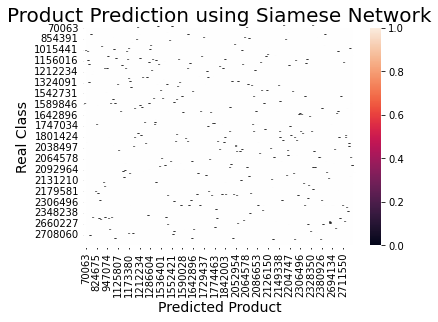

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_confusion, annot=True)

plt.title('Product Prediction using Siamese Network', fontsize=20)

plt.xlabel('Predicted Product', fontsize=14)

plt.ylabel('Real Class', fontsize=14)

plt.show()

In [ ]:
fp_tp_dict = dict()
confusion_matrix = dict()
for i in mid_categ_list:
    t_count = 0
    f_count = 0
    fp_tp_dict[i] = {'T':t_count, 'F':f_count}
    
    confusion_column = {i :[j for j in mid_categ_list]}
for i, row in df_photoReview_002_apn_sim_matrix.iloc[0:].iterrows():
    min_index = np.argsort(df_photoReview_002_apn_sim_matrix.iloc[i, 10:])[1]
#     print(df_photoReview_002_apn_sim_matrix.loc[min_index]["mid_category"])
#     print(df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"])
    if df_photoReview_002_apn_sim_matrix.loc[min_index]["mid_category"] == df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]:
        fp_tp_dict[df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]]['T'] += 1
        
    else: 
        fp_tp_dict[df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]]['F'] += 1

,filename,width,height,xmin,ymin,xmax,ymax,goods_id,mid_category,goods_image,...,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/1886950_0_gallery_60c4db34d6a73_jpg.rf.02412814c2859dcd265abdc02253805d.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2086653_0_gallery_62345888dc0dc_jpg.rf.605d5833006597c62385edf30f82d9f7.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2086653_0_gallery_630cd1178dabc_jpg.rf.e3fd3b9698875329092871551b73e4ab.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_620f9b230cce4_jpg.rf.d1717f819e67847d7f5cde4ed1c208bb.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_6316f1600ad9e_jpg.rf.224b174654773eb4f98f60ba03a7f950.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_624edccab0471_jpg.rf.b9a493c5adac519226c42cf054144357.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_625ff9c56c7b4_jpg.rf.7d29f515a9412da00eb68da67f4039b5.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_620f9ac6e3190_jpg.rf.0f6050783bd8032610caecca31d6674a.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_62af3eee9692a_jpg.rf.08f58629363a3fff35470c6c213734bf.jpg,distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2122566_0_gallery_625ff9c626d39_jpg.rf.0e6bd8f9d103e35dca0170e8f42cfed5.jpg
0,324416_0_gallery_60db0f3fda63b_jpg.rf.c122b1e0...,268,387,0,0,268,387,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,0.8209603,0.9290541,0.54703856,0.9376637,0.88988256,0.9144054,0.58323246,0.625577,1.2236446,1.5133655
1,324416_0_gallery_5f853b8b0c6cf_jpg.rf.2b9accc0...,299,219,0,0,299,219,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,1.2305309,0.3904549,0.96406,0.5526585,0.52677226,0.8197176,0.9162015,0.9945441,0.72917306,1.0744423
2,324416_0_gallery_5ea26b7970d44_jpg.rf.ec7dcbe5...,513,398,0,0,513,398,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,0.731051,1.0198026,0.44941685,1.0187114,0.9947051,1.0200989,0.7284517,0.6408458,1.404703,1.6803558
3,324416_0_gallery_60e300731d5a3_jpg.rf.78c96a5d...,336,353,0,0,336,353,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,1.4692386,0.67805594,1.1478335,0.7746029,0.75983757,0.92624134,1.0514166,1.148074,0.59072566,0.9950843
4,324416_0_gallery_5ebe49650f317_jpg.rf.6521b54e...,488,608,0,0,488,608,324416,001001,https://image.msscdn.net/images/goods_img/2016...,...,0.91926277,0.9940562,0.60557234,1.0683688,1.052838,1.130725,0.49393377,0.84449905,1.3357196,1.4083827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2122566_0_gallery_624edccab0471_jpg.rf.b9a493c...,265,320,0,1,265,320,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,1.0217116,0.6937356,0.9379304,0.57909703,0.52012134,0.0,1.0948699,0.8279769,0.9866054,1.5993536
260,2122566_0_gallery_625ff9c56c7b4_jpg.rf.7d29f51...,161,255,0,0,161,255,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,0.969857,0.9537809,0.66606843,1.0382301,0.9766171,1.0948699,0.0,0.82978654,1.1878401,1.3277819
261,2122566_0_gallery_620f9ac6e3190_jpg.rf.0f60507...,176,143,0,0,176,143,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,0.6504293,0.86287105,0.57612884,0.86997,0.82314014,0.8279769,0.82978654,0.0,1.2670008,1.7356935
262,2122566_0_gallery_62af3eee9692a_jpg.rf.08f5862...,300,339,0,0,300,339,2122566,001001,https://image.msscdn.net/images/goods_img/2021...,...,1.5961927,0.7585835,1.3128743,0.8407239,0.82034993,0.9866054,1.1878401,1.2670008,0.0,1.0649102
